In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
import matplotlib.pyplot as plt
from scipy.io import wavfile
%matplotlib inline

In [2]:
UPLOAD_DIR='./uploads'
DATE_DIR = './data'

In [3]:
def precess_raw_file(input_file, output_file, max_sec, input_format='wav'):
    
    max_sec = max_sec * 1000
    
    sound = AudioSegment.from_file(input_file, format=input_format)
    
    padding = AudioSegment.silent(duration=max_sec)
    segment = sound[:max_sec]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(output_file, format='wav')
    

In [4]:
def process_dir(dire):
    i = 0
    for file in os.listdir(os.path.join(UPLOAD_DIR, dire)):
        if file.endswith('wav'):
            os.makedirs(os.path.join(DATE_DIR, dire), exist_ok=True)
            precess_raw_file(os.path.join(UPLOAD_DIR, dire, file), \
                             os.path.join(DATE_DIR, dire, str(i)+'.wav'), 2)
            i+=1

In [5]:
process_dir('positives')
process_dir('negatives')

In [6]:
# Calculate and plot spectrogram for a wav audio file
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return np.swapaxes(pxx, 0, 1)

# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

# Used to standardize volume of audio clip
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

# Load raw audio files for speech synthesis
def load_raw_audio():
    positives = []
    backgrounds = []
    negatives = []
    for filename in os.listdir("./data/positives"):
        if filename.endswith("wav"):
            positive = AudioSegment.from_wav("./data/positives/"+filename)
            positives.append(positive)

    for filename in os.listdir("./data/negatives"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav("./data/negatives/"+filename)
            negatives.append(negative)
    return positives, negatives

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7609: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(1101, 101)

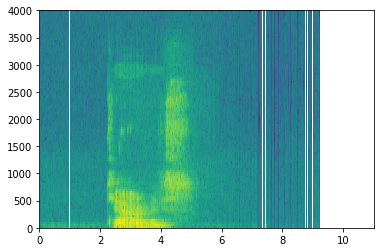

In [8]:
x = graph_spectrogram(DATE_DIR+"/positives/4.wav")
x.shape

## Actual model

In [9]:
Tx = 1101 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 272 # The number of time steps in the output of our model

In [10]:
# Load audio segments using pydub 
positives, negatives = load_raw_audio()

# Maybe around 1000, since an "activate" audio clip is usually around 1 sec (but varies a lot)
# Different "activate" clips can have different lengths 
print("jarvis[0] len: " + str(len(positives[0])))
print("jarvis[1] len: " + str(len(positives[1])))

jarvis[0] len: 2000
jarvis[1] len: 2000


# Generate training set

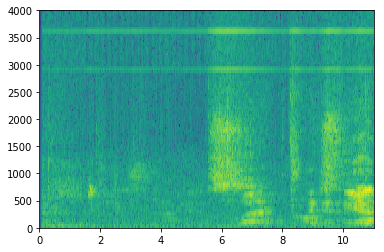

In [14]:
X_list = []
y_list = []
for file in os.listdir(DATE_DIR+"/positives"):
    if file.endswith('wav'):
        _t = graph_spectrogram(DATE_DIR+"/positives/"+file)
        X_list.append(_t)
        y_list.append(1)
for file in os.listdir(DATE_DIR+"/negatives"):
    if file.endswith('wav'):
        _t = graph_spectrogram(DATE_DIR+"/negatives/"+file)
        X_list.append(_t)
        y_list.append(0)

In [23]:
X = np.array(X_list)
y = np.array(y_list)

In [24]:
indexes = np.random.permutation(X.shape[0])
X = X[indexes]
y = y[indexes]
print(X.shape, y.shape)

(24, 1101, 101) (24,)


# 2 - Model

Now that you've built a dataset, lets write and train a trigger word detection model! 

The model will use 1-D convolutional layers, GRU layers, and dense layers. Let's load the packages that will allow you to use these layers in Keras. This might take a minute to load. 

In [25]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape, CuDNNGRU, Lambda
from keras.optimizers import Adam
from keras.regularizers import l2
import keras.backend as K

In [26]:
# GRADED FUNCTION: model

def create_model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(64, kernel_size=3, strides=1)(X_input)                                 # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(0.5)(X)                                 # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = CuDNNGRU(units = 32, return_sequences = True)(X)  # GRU (use 128 units and return the sequences)
    X = Dropout(0.5)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = CuDNNGRU(units = 32, return_sequences = True)(X)                                 # GRU (use 128 units and return the sequences)
    X = Dropout(0.5)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Dropout(0.5)(X)                                 # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "relu"))(X) # time distributed  (sigmoid)
    
    X = Lambda(lambda x: K.squeeze(x, 2))(X)
    
    X = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))(X)
    
    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [27]:
model = create_model(input_shape = (Tx, n_freq))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1101, 101)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1099, 64)          19456     
_________________________________________________________________
batch_normalization_4 (Batch (None, 1099, 64)          256       
_________________________________________________________________
activation_2 (Activation)    (None, 1099, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1099, 64)          0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 1099, 32)          9408      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1099, 32)          0         
__________

In [28]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=["accuracy"])

In [45]:
losses = []
for i in range(10):
    filepath = './models/bin_epoch_'
    history = model.fit(X, y, batch_size = 5, epochs=1, shuffle=True)
    losses.append(history.history['loss'][0])
    model.save_weights(filepath+str(i+1)+'.h5')

Epoch 1/1
24/24 [==============================] - 0s 14ms/step - loss: 0.2789 - acc: 0.8750
Epoch 1/1
24/24 [==============================] - 0s 15ms/step - loss: 0.2997 - acc: 0.7917
Epoch 1/1
24/24 [==============================] - 0s 14ms/step - loss: 0.3020 - acc: 0.7917
Epoch 1/1
24/24 [==============================] - 0s 14ms/step - loss: 0.3005 - acc: 0.7500
Epoch 1/1
24/24 [==============================] - 0s 14ms/step - loss: 0.3004 - acc: 0.7917
Epoch 1/1
24/24 [==============================] - 0s 14ms/step - loss: 0.2495 - acc: 0.9583
Epoch 1/1
24/24 [==============================] - 0s 14ms/step - loss: 0.2542 - acc: 0.8750: 0s - loss: 0.1861 - acc: 0.86
Epoch 1/1
24/24 [==============================] - 0s 14ms/step - loss: 0.3531 - acc: 0.7917
Epoch 1/1
24/24 [==============================] - 0s 14ms/step - loss: 0.2918 - acc: 0.8333
Epoch 1/1
24/24 [==============================] - 0s 15ms/step - loss: 0.2981 - acc: 0.7917


In [46]:
model.load_weights('./models/bin_epoch_6.h5')

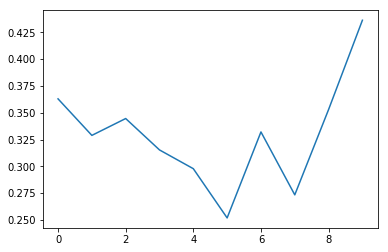

In [42]:
plt.plot(losses)

In [47]:
MODEL_PATH='../website/models'
def save_model(model):
    # serialize model to JSON
    model_json = model.to_json()
    with open(MODEL_PATH+"/model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(MODEL_PATH+"/model.h5")
    print("Saved model to disk")
save_model(model)

Saved model to disk


## 2.3 - Test the model

Finally, let's see how your model performs on the dev set.

In [191]:
loss, acc = model.evaluate(X, Y)
print("Dev set accuracy = ", acc)

NameError: name 'Y' is not defined

This looks pretty good! However, accuracy isn't a great metric for this task, since the labels are heavily skewed to 0's, so a neural network that just outputs 0's would get slightly over 90% accuracy. We could define more useful metrics such as F1 score or Precision/Recall. But let's not bother with that here, and instead just empirically see how the model does. 

# 3 - Making Predictions

Now that you have built a working model for trigger word detection, let's use it to make predictions. This code snippet runs audio (saved in a wav file) through the network. 

<!--
can use your model to make predictions on new audio clips.

You will first need to compute the predictions for an input audio clip.

**Exercise**: Implement predict_activates(). You will need to do the following:

1. Compute the spectrogram for the audio file
2. Use `np.swap` and `np.expand_dims` to reshape your input to size (1, Tx, n_freqs)
5. Use forward propagation on your model to compute the prediction at each output step
!-->

In [206]:
process_dir('dev/negatives')
process_dir('dev/positives')

In [ ]:
th = 0.8

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7609: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


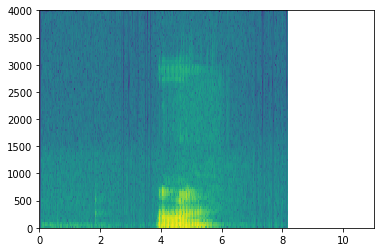

In [26]:
tx = graph_spectrogram(DATE_DIR+"/dev/negatives/1.wav")
tx = np.expand_dims(tx, 0)

In [28]:
preds = model.predict(tx)

In [30]:
preds[0,0]

0.785447

In [ ]:
for i in range(preds.shape[1]):
    if c_preds[0, i, 0] == 1 or Y[p_idx, i, :] == 1:
        print(i, preds[0, i, 0], c_preds[0, i, 0], Y[p_idx, i, :])

In [ ]:
def prediction_to_label(predictions, threshold):
    
    results = []
    Ty = predictions.shape[1]
    consecutive_timesteps = 0
    
    for i in range(Ty):
        consecutive_timesteps += 1
        
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            results.append((True, i - 75, i))
            consecutive_timesteps = 0
        
    return results

In [ ]:
prediction_to_label(preds, th)

In [ ]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')

Once you've uploaded your audio file to Coursera, put the path to your file in the variable below.

In [ ]:
your_filename = './raw_data/jarvis/2.wav'

In [ ]:
preprocess_audio(your_filename)
IPython.display.Audio(your_filename) # listen to the audio you uploaded 

Finally, use the model to predict when you say activate in the 10 second audio clip, and trigger a chime. If beeps are not being added appropriately, try to adjust the chime_threshold.

In [ ]:
prediction = detect_triggerword(your_filename)